# Loading Files and Pre-Processing

In [1]:
import mne
import numpy as np
from scipy.signal import welch, stft
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from collections import Counter

# List of EDF file paths to load
edf_files = [
    # r"C:\Users\kyled\Downloads\Zak.edf",
#     r"C:\Users\kyled\Downloads\Elisa1_good.edf",
#     r"C:\Users\kyled\Downloads\Elisa2_good.edf",
    r"C:\Users\kyled\Downloads\Pirotta.edf",
    r"C:\Users\kyled\Downloads\Pirotta2.edf",
    r"C:\Users\kyled\Downloads\Pirotta3.edf",
    r"C:\Users\kyled\Downloads\Pirotta4.edf",
    # r"C:\Users\kyled\Downloads\Jake.edf",
    # r"C:\Users\kyled\Downloads\Claire1.edf",
#     r"C:\Users\kyled\Downloads\Claire2.edf",
#     r"C:\Users\kyled\Downloads\Claire3.edf"
]

# Loading the first file to use as a reference for channel names
print("Loading reference EDF file...")
reference_raw = mne.io.read_raw_edf(edf_files[0], preload=True)
reference_channels = reference_raw.info['ch_names']

raw_objects = []
for file_path in edf_files:
    print(f"Loading and cropping EDF file: {file_path}...")
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.crop(tmin=60, tmax=361)
    raw.pick_channels(reference_channels)
    raw_objects.append(raw)

# Concatenating all loaded and processed objects
print("Concatenating all processed EDF files...")
raw = mne.concatenate_raws(raw_objects)

# Pre-processing the combined data
print("Filtering data...")
raw.filter(4, 30)
sfreq = raw.info['sfreq']

epoch_duration = 30  # seconds
start_times = np.arange(0, raw.times[-1] - epoch_duration, epoch_duration)
end_times = start_times + epoch_duration

words = ['yes', 'no', 'more', 'stop', 'help', 'want', 'eat', 'drink', 'I', 'you']

Loading reference EDF file...
Extracting EDF parameters from C:\Users\kyled\Downloads\Pirotta.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 46847  =      0.000 ...   365.992 secs...
Loading and cropping EDF file: C:\Users\kyled\Downloads\Pirotta.edf...
Extracting EDF parameters from C:\Users\kyled\Downloads\Pirotta.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 46847  =      0.000 ...   365.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loading and cropping EDF file: C:\Users\kyled\Downloads\Pirotta2.edf...
Extracting EDF parameters from C:\Users\kyled\Downloads\Pirotta2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 46463  =      0.000 ...   362.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loading and cropping EDF file: C:\Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


# Feature Extraction

In [2]:
def extract_features(epoch_data, sfreq):
    mean_vals = np.mean(epoch_data, axis=1)
    std_vals = np.std(epoch_data, axis=1)
    skew_vals = skew(epoch_data, axis=1)
    kurt_vals = kurtosis(epoch_data, axis=1)
    freqs, psd = welch(epoch_data, sfreq, nperseg=int(sfreq))
    theta_power = psd[:, (freqs > 4) & (freqs <= 8)].mean(axis=1)
    alpha_power = psd[:, (freqs > 8) & (freqs <= 12)].mean(axis=1)
    beta_power = psd[:, (freqs > 12) & (freqs <= 30)].mean(axis=1)
    _, _, Zxx = stft(epoch_data, fs=sfreq, nperseg=int(sfreq/2))
    stft_power = np.abs(Zxx).mean(axis=2)
    entropy_vals = np.array([entropy(np.abs(epoch_data[channel, :])) for channel in range(epoch_data.shape[0])])

    features = np.stack([
        mean_vals,
        std_vals,
        skew_vals,
        kurt_vals,
        theta_power,
        alpha_power,
        beta_power,
        stft_power.mean(axis=1),
        entropy_vals
    ], axis=1)

    return features

print("Segmenting data into 30-second epochs, then into 2-second sub-epochs, and extracting features...")
labeled_features_data = []
sub_epoch_duration = 2  # in seconds
for i, (start, end) in enumerate(zip(start_times, end_times)):
    start_sample = int(start * sfreq)
    end_sample = int(end * sfreq)
    epoch_data, _ = raw[:, start_sample:end_sample]
    word_label = words[i % len(words)]
    
    for j in range(int(epoch_duration / sub_epoch_duration)):
        sub_start = j * sub_epoch_duration * int(sfreq)
        sub_end = (j + 1) * sub_epoch_duration * int(sfreq)
        sub_epoch_data = epoch_data[:, sub_start:sub_end]
        features = extract_features(sub_epoch_data, sfreq)
        labeled_features_data.append((features, word_label))

# Extracting features and labels from the collected data
features, labels = zip(*labeled_features_data) if labeled_features_data else ([], [])
features = np.array(features) if features else np.empty((0, 0))
labels = np.array(labels)
    
# Flattening the last two dimensions of the features array
features_2d = features.reshape(features.shape[0], -1)

# Handling NaN values: replacing them with the column mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
features_imputed = imputer.fit_transform(features_2d)

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

Segmenting data into 30-second epochs, then into 2-second sub-epochs, and extracting features...


C:\Users\kyled\anaconda3\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


# Feature Selection

In [3]:
# PCA
pca = PCA(n_components=0.95) 
features_pca = pca.fit_transform(features_scaled)

# Mutual Information
num_sub_epochs_per_epoch = int(epoch_duration / sub_epoch_duration)
total_sub_epochs = num_sub_epochs_per_epoch * len(start_times)

num_features = features_scaled.shape[1]
k_best = min(num_features, 20)  # Ensure k does not exceed the number of available features
mi_selector = SelectKBest(mutual_info_classif, k=k_best)
features_mi = mi_selector.fit_transform(features_scaled, labels)

# Choosing feature set to use for further model training
selected_features = features_mi

num_features_mi = features_mi.shape[1]  # Number of features after MI

# Splitting into Train, Validation and Test sets

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(
    selected_features, labels, test_size=0.3, random_state=42, stratify=labels)

val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

print(f"Training data size: {len(train_features)}")
print(f"Validation data size: {len(val_features)}")
print(f"Testing data size: {len(test_features)}")

# Counting occurrences of each label in the training, validation, and testing sets
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

# Calculating the total number of samples in each set
total_train = len(train_labels)
total_val = len(val_labels)
total_test = len(test_labels)

# Printing the distribution of each label in each set
print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"{label}: {count} ({count / total_train * 100:.2f}%)")

print("\nValidation set label distribution:")
for label, count in val_label_counts.items():
    print(f"{label}: {count} ({count / total_val * 100:.2f}%)")

print("\nTesting set label distribution:")
for label, count in test_label_counts.items():
    print(f"{label}: {count} ({count / total_test * 100:.2f}%)")

Training data size: 420
Validation data size: 90
Testing data size: 90
Training set label distribution:
more: 42 (10.00%)
drink: 42 (10.00%)
you: 42 (10.00%)
I: 42 (10.00%)
help: 42 (10.00%)
eat: 42 (10.00%)
yes: 42 (10.00%)
stop: 42 (10.00%)
no: 42 (10.00%)
want: 42 (10.00%)

Validation set label distribution:
help: 9 (10.00%)
more: 9 (10.00%)
no: 9 (10.00%)
stop: 9 (10.00%)
drink: 9 (10.00%)
eat: 9 (10.00%)
want: 9 (10.00%)
I: 9 (10.00%)
yes: 9 (10.00%)
you: 9 (10.00%)

Testing set label distribution:
want: 9 (10.00%)
you: 9 (10.00%)
drink: 9 (10.00%)
eat: 9 (10.00%)
no: 9 (10.00%)
stop: 9 (10.00%)
more: 9 (10.00%)
help: 9 (10.00%)
yes: 9 (10.00%)
I: 9 (10.00%)


# Building the Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class EEGTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=256, nhead=8, num_layers=16, dim_feedforward=512, dropout_rate=0.1, noise_std=0.01):
        super(EEGTransformer, self).__init__()
        self.noise_std = noise_std
        self.linear_in = nn.Linear(input_dim, d_model)
        self.dropout_in = nn.Dropout(dropout_rate)
        
        # Using pre-LayerNorm
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                dim_feedforward=dim_feedforward, 
                                                dropout=dropout_rate, 
                                                activation='gelu', 
                                                norm_first=True)

        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.batch_norm = nn.BatchNorm1d(d_model)
        self.linear_out = nn.Linear(d_model, num_classes)
        self.dropout_out = nn.Dropout(dropout_rate)

    def forward(self, x):
        if self.training and self.noise_std > 0.0:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise

        x = self.linear_in(x)
        x = self.dropout_in(x)
        
        x = self.transformer_encoder(x)  # Transformer encoder with pre-LayerNorm

        x = self.batch_norm(x)
        x = self.dropout_out(x)
        x = self.linear_out(x)

        return F.log_softmax(x, dim=1)

model = EEGTransformer(input_dim=num_features_mi, num_classes=10)
print(model)


EEGTransformer(
  (linear_in): Linear(in_features=20, out_features=256, bias=True)
  (dropout_in): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-15): 16 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_out): Linear(in_features=256, out_features=10

C:\Users\kyled\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Creating Datasets

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# Encoding string labels to integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(test_labels)
print(test_labels_encoded)
    
train_dataset = EEGDataset(train_features, train_labels_encoded)
val_dataset = EEGDataset(val_features, val_labels_encoded)
test_dataset = EEGDataset(test_features, test_labels_encoded)

# Defining DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


['want' 'want' 'you' 'drink' 'eat' 'drink' 'no' 'stop' 'drink' 'more'
 'more' 'help' 'yes' 'you' 'drink' 'stop' 'you' 'yes' 'eat' 'I' 'you'
 'stop' 'no' 'you' 'no' 'no' 'stop' 'yes' 'want' 'help' 'more' 'I' 'want'
 'help' 'no' 'more' 'stop' 'help' 'more' 'eat' 'no' 'more' 'want' 'help'
 'no' 'eat' 'you' 'stop' 'stop' 'drink' 'yes' 'I' 'I' 'yes' 'yes' 'eat'
 'drink' 'you' 'I' 'yes' 'want' 'more' 'stop' 'you' 'help' 'yes' 'want'
 'drink' 'eat' 'more' 'help' 'want' 'yes' 'help' 'no' 'eat' 'eat' 'I'
 'you' 'eat' 'I' 'help' 'more' 'want' 'drink' 'no' 'I' 'I' 'stop' 'drink']
[7 7 9 1 2 1 5 6 1 4 4 3 8 9 1 6 9 8 2 0 9 6 5 9 5 5 6 8 7 3 4 0 7 3 5 4 6
 3 4 2 5 4 7 3 5 2 9 6 6 1 8 0 0 8 8 2 1 9 0 8 7 4 6 9 3 8 7 1 2 4 3 7 8 3
 5 2 2 0 9 2 0 3 4 7 1 5 0 0 6 1]


# Training Loop

In [7]:
import torch
import torch.nn.functional as F

# Training parameters
learning_rate = 1e-5
epochs = 600

# Using CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-8)

train_accuracies = []
val_accuracies = []

l1_lambda = 0.0001

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for features, labels in train_loader:
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, labels)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm  # L1 regularization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        predictions = torch.max(output, 1)[1]
        train_correct += (predictions == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = train_correct / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for features, labels in val_loader:
            output = model(features)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.max(output, 1)[1]
            val_correct += (predictions == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = val_correct / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Loss: {train_loss / total_train}, Training Accuracy: {train_accuracy}, '
          f'Validation Loss: {val_loss / total_val}, Validation Accuracy: {val_accuracy}')

Epoch 1, Loss: 0.14126808529808407, Training Accuracy: 0.16904761904761906, Validation Loss: 0.03743862311045329, Validation Accuracy: 0.18888888888888888
Epoch 2, Loss: 0.14106155577160062, Training Accuracy: 0.1738095238095238, Validation Loss: 0.031242224905225966, Validation Accuracy: 0.18888888888888888
Epoch 3, Loss: 0.14072491782052177, Training Accuracy: 0.24523809523809523, Validation Loss: 0.027362563874986437, Validation Accuracy: 0.2222222222222222
Epoch 4, Loss: 0.1401937893458775, Training Accuracy: 0.24761904761904763, Validation Loss: 0.025134860144721136, Validation Accuracy: 0.2222222222222222
Epoch 5, Loss: 0.14002497082664853, Training Accuracy: 0.2619047619047619, Validation Loss: 0.023374570740593806, Validation Accuracy: 0.24444444444444444
Epoch 6, Loss: 0.1395863169715518, Training Accuracy: 0.3047619047619048, Validation Loss: 0.02227629025777181, Validation Accuracy: 0.2222222222222222
Epoch 7, Loss: 0.13937938326881044, Training Accuracy: 0.31666666666666665

# Evaluating Model Performance

### Calculating Metrics

In [8]:
from sklearn.metrics import precision_recall_fscore_support

test_loss = 0.0
test_correct = 0
total_test = 0

all_test_predictions = []
all_test_labels = []

# Setting model to evaluation mode
model.eval()

with torch.no_grad():
    for features, labels in test_loader:
        output = model(features)
        loss = criterion(output, labels)
        test_loss += loss.item()
        predictions = torch.max(output, 1)[1]
        test_correct += (predictions == labels).sum().item()
        total_test += labels.size(0)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / total_test

print(f'Test Loss: {test_loss / total_test}, Test Accuracy: {test_accuracy}')

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='macro')
print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1_score:.4f}')

Test Loss: 0.00331151286760966, Test Accuracy: 0.8888888888888888
Test Precision: 0.9068, Test Recall: 0.8889, Test F1 Score: 0.8881


### Designing Confusion Matrix

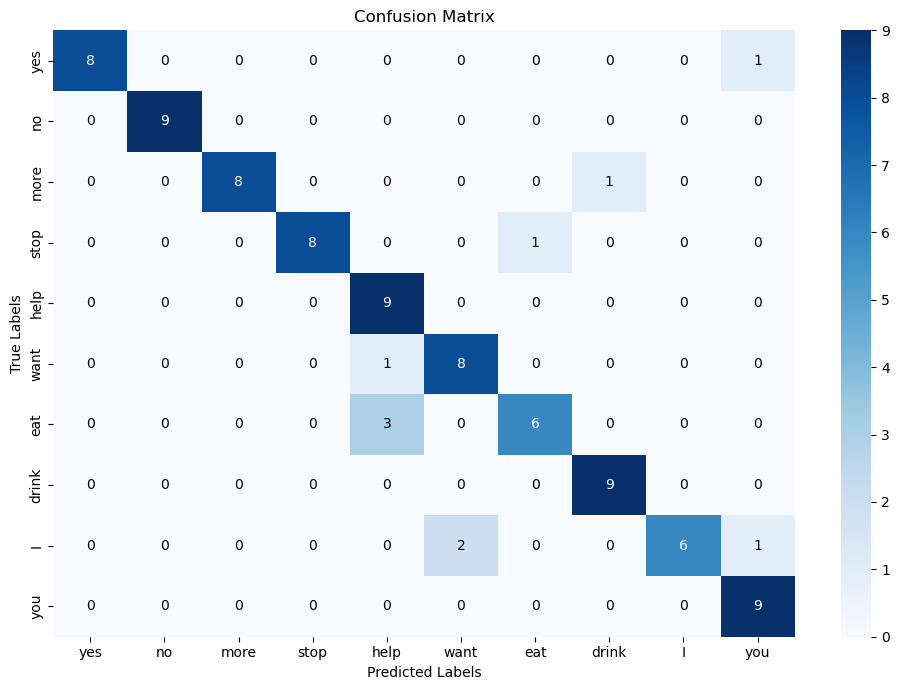

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

label_names = ['yes', 'no', 'more', 'stop', 'help', 'want', 'eat', 'drink', 'I', 'you']

# Collecting all predictions and true labels
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        output = model(features)
        predictions = torch.max(output, 1)[1]
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Computing the confusion matrix
cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(10))  # Adjust labels range based on your actual labels

plt.figure(figsize=(10, 7))
# Creating the heatmap using seaborn
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)

# Threshold for colors
threshold = cm.max() / 2.

# Looping over the cells to change the text color based on the background
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, cm[i, j],
                horizontalalignment='center',
                verticalalignment='center',
                color="white" if cm[i, j] > threshold else "black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# ax.invert_yaxis()  # Invert the y-axis to have labels in reverse order
plt.tight_layout() 
plt.show()

### Designing line-graph showing training and validation over time

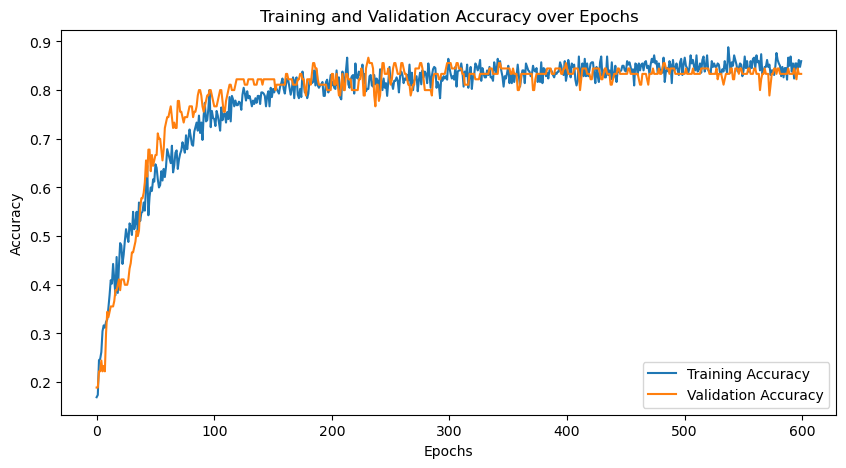

In [10]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()